# [E-07] 셸로우 포커싱을 적용한 인물사진 만들기

    보통 DSLR, 혹은 미러리스 카메라로만 제대로 구현할 수 있는 포커싱 기능을 인공지능을 통해 구현해 본다. 기존의 카메라가 이미지를 출력하기 이전에 focusing을 통해 배경을 블러 처리 했다면 이번에는 이미 출력된 이미지의 배경을 블러처리 하는것이 차이점이라 할 수 있다. 순서는 아래와 같다. 

    1. 샘플 이미지 준비
    2. segmentation 모델 준비
    2. 모델로 이미지 내 사람과 배경 분리하기 
    4. 분리된 배경 블러처리 하기 
    5. 흐린 배경과 원본 이미지 합성 
    6. 고양이 이미지에 out-focusing 구현하기
    7. 배경전환 크로마키 사진
    8. 다양한 이미지를 통해 문제점 파악하기 
    9. 후기 

## 1. 샘플 이미지 준비

### 라이브러리 import

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('라이브러리 import 완료')

라이브러리 import 완료


### 이미지 불러오기

(1280, 960, 3)


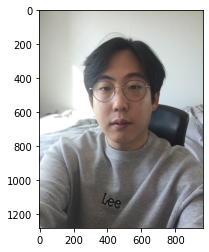

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 2. segmentation 모델 준비

### DeepLab 세그멘테이션 모델 다운로드

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f3785e3fc40>)

### 다운로드한 모델을 이용하여 사용할 세그멘테이션 모델 생성

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### PASCAL VOC  데이터의 분류 label 확인
    DeelLab의 segmentation 모델은 PASCAL VOC 데이터로 학습된 모델이다. 따라서 어떤 데이터를 학습시켰는지 확인하여 모델을 이해할 필요가 있다. 

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

    총 21개의 클래스로 분류 학습된 것을 알 수 있다. 

## 3. 모델로 이미지 내 사람과 배경 분리하기

### 모델에 이미지 입력

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

### 모델의 출력값 확인

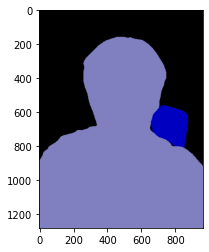

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


output 을 통해 이미지 내 경계가 어떻게 분류되었는지 각기 다른 색상으로 표시되어 확인할 수 있다. segvalues에는 class_ids와 masks를 알 수 있고, class_ids를 통해 분류된 각기 다른 색상들이 어떤 특정 물체로 분류되었는지 알 수 있다. 

### 각 물체 output이 어떤 색상을 나타내고 있는지 살펴보기

In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

모델을 거쳐 처리된 데이터의 배열을 인덱스 20까지 대충 살펴보면 0, 64, 128, 192까지 총 4가지의 값이 눈에 띈다. 이 중에서 어떤 값이 사람을 표시하고 있는지 알아내어야 한다. 

### 사람으로 분류된 데이터 값 확인
사람은 클래스 15로 분류되어 있으므로 15를 넣어 해당하는 데이터 값을 확인해 본다. 

In [11]:
colormap[15]

array([192, 128, 128])

### BGR to RGB

In [12]:
seg_color = (128,128,192)

### seg_color로 이루어진 마스크 만들기

(1280, 960)


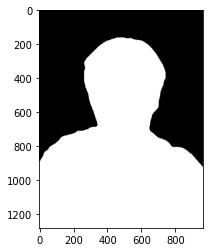

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

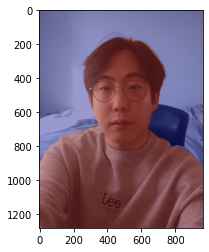

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 이미지 블러(흐리게) 처리하기

### blur() 함수를 이용해 이미지 블러 처리하기

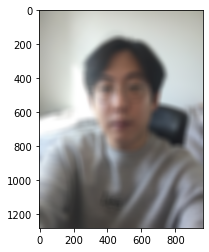

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (40,40))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 블러 처리한 이미지와 원본 이미지 합성하여 out-focusing 효과 구현하기

### 블러 처리한 이미지에서 사람을 제외하고 배경만 추출하기

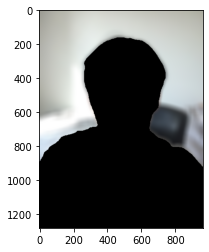

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 추출한 배경을 원본 사람 이미지와 합성하기

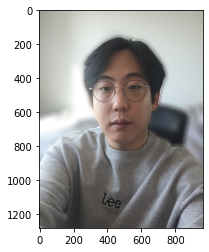

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 6. 고양이 이미지에 out-focusing 효과 구현하기

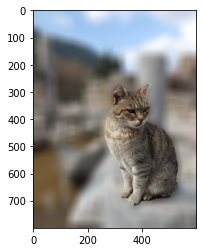

In [18]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_1.jpg'  
img_orig = cv2.imread(img_path) 

segvalues, output = model.segmentAsPascalvoc(img_path)

seg_color = (0,0,64)
seg_map = np.all(output==seg_color, axis=-1)

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (40,40))  

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

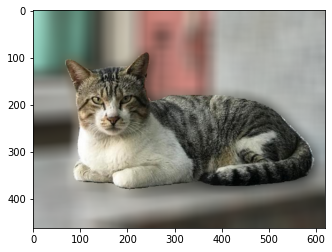

In [19]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_2.jpg'  
img_orig = cv2.imread(img_path) 

segvalues, output = model.segmentAsPascalvoc(img_path)

seg_color = (0,0,64)
seg_map = np.all(output==seg_color, axis=-1)

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (40,40))  

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 7. 배경전환 크로마키사진 

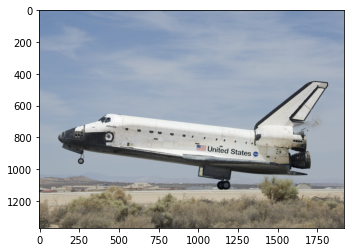

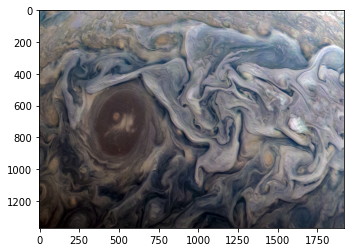

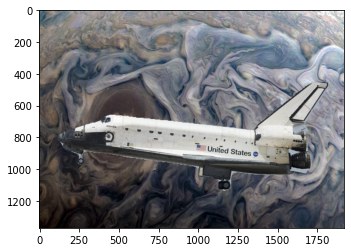

In [20]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/shuttle_2.jpg'  
img_orig = cv2.imread(img_path) 

img_path_bgr = os.getenv('HOME')+'/aiffel/human_segmentation/images/jupiter_1.jpg'  
img_bgr = cv2.imread(img_path_bgr)
img_bgr = cv2.resize(img_bgr, (1920, 1370)) 

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

segvalues, output = model.segmentAsPascalvoc(img_path)

seg_color = (0,0,128)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_bgr, img_bg_mask)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 다양한 이미지를 통해 문제점 파악하기 

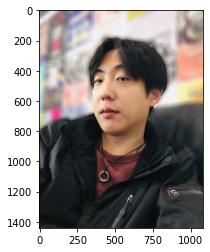

In [21]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/test_1.jpg'  
img_orig = cv2.imread(img_path) 

segvalues, output = model.segmentAsPascalvoc(img_path)

seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1)

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (40,40))  

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

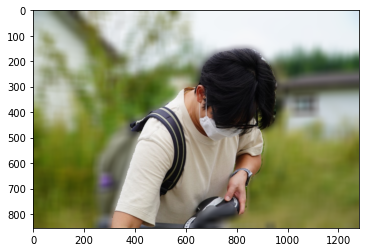

In [22]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/test_2.jpg'  
img_orig = cv2.imread(img_path) 

segvalues, output = model.segmentAsPascalvoc(img_path)

seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1)

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (40,40))  

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

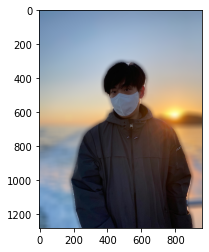

In [23]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/test_3.jpg'  
img_orig = cv2.imread(img_path) 

segvalues, output = model.segmentAsPascalvoc(img_path)

seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1)

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (40,40))  

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

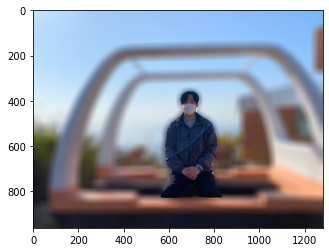

In [24]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/test_4.jpg'  
img_orig = cv2.imread(img_path) 

segvalues, output = model.segmentAsPascalvoc(img_path)

seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1)

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (40,40))  

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

모델의 개선을 위해 각 사진의 공통적인 아쉬운 점을 살펴보았다. 블러가 적용된 모든 이미지는 피사체와 배경간 피사계의 심도가 깊고 얕음에 관계없이 분류된 Class의 경계선대로 out-focusing되며 자연스럽지 못한 원근감을 가지게 됨을 알 수 있다. 모델이 이미지 내의 피사계 심도를 제대로 인식하지 못하는 문제를 개선하고 의도했던 out-focusing 효과가 자연스럽게 연출되려면 2D 이미지를 3D로 전환한 후 이미지 내 피사계의 심도에 따라 focusing이 조절될 수 있도록 학습 과정을 재설계해야 한다. 따라서 개선을 위해 해결해야 할 문제를 '2D 이미지를 3D 이미지로 전환하여 모델의 Depth 인식 개선'으로 정의하고 지금 적용할 수 있는 방법을 찾아보았다. 

## 참고문헌
1. https://paperswithcode.com/task/depth-estimation 여러가지 Depth Estimation에 관한 논문이 수록되어 있다. 
2. https://arxiv.org/pdf/1803.10039.pdf Lei he, Guanghui Wang(2018) "Learning Depth from Single Images with Deep Neural Network Embedding focal Length"

# 9. 후기
위에 언급했듯 피사계 심도를 설정하기 위한 Key solution으로 '2D 이미지의 3D전환, Depth 설정'을 적용하고 싶었으나 당장 쉽게 적용할 수 있는 방법은 찾지 못했고 제한된 시간 내에 찾았던 모든 방법은 논문상 기술 구현을 통해 가능했으며 논문 작성 시기도 대부분 2019~2021년에 머물러 있을 만큼 최신 기술들이었다. 열심히 읽어보려 시도했으나 아쉽게도 지금 당장 이해하기엔 어려움이 많았고 조금이나마 이해해서 시도해보면 좋겠다고 생각했던 논문 하나를 꼽자면 "Lerning Depth from Single Images with Deep Neural Network Embedding focal Length"(참고문헌 2번)논문의 3D Converting 기술을 직접 구현할 수 있으면 좋겠다고 생각했다. 그 이유로 그나마 좀 다루어 본 모델인 CNN을 바탕으로 기술구현을 서술하고 있었으며 Converting data의 대상이 Single Image이기에 내가 구현한 모델에 적용할 Solution과 최적화된 기술이라고 생각되었다. 마지막으로 이번 노드를 학습하며 2D data를 3D로 전환하면서 정말 많은 가능성이 생긴다는 인사이트를 얻을 수 있었고 그에 반해 아직 기술상용화가 제대로 이루어지지 않아 얼마든지 새로운 영역을 누구든 개척할 수 있을것이라 생각이 들었다. 